#  Forecasting Monthly EV Sales


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

## Data Loading and Preprocessing

In [2]:
# Load data
df = pd.read_csv(r"e:/Nieuw dataset/Joined trends/joined_trend_sales_All1.csv")
df["Periode"] = pd.to_datetime(df["Periode"], format="%Y/%m")
df = df.sort_values("Periode").reset_index(drop=True)

# Create lag features and date parts
for lag in range(1, 7):
    df[f"TVV_Lag{lag}"] = df["Totaal_verkochte_wegvoertuigen"].shift(lag)
df_lagged = df.dropna().reset_index(drop=True)
df_lagged['year'] = df_lagged['Periode'].dt.year
df_lagged['month'] = df_lagged['Periode'].dt.month
df_lagged['quarter'] = df_lagged['Periode'].dt.quarter
cols = [col for col in df_lagged.columns if col != 'Totaal_verkochte_wegvoertuigen'] + ['Totaal_verkochte_wegvoertuigen']
df_lagged = df_lagged[cols]

In [3]:
lag_time_features = [f'TVV_Lag{i}' for i in range(1, 7)] + ['year', 'month', 'quarter']
feature_sets = {
    'Lag Only': lag_time_features,
    'All Features': [col for col in df_lagged.columns if col not in ['Periode', 'Totaal_verkochte_wegvoertuigen']]


}


# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    ' (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features


In [4]:
print(df.head())

     Periode  thuis opladen  elektrische auto  hybride elektrisch  \
0 2007-01-01              0                 1                   0   
1 2007-02-01              0                 0                   0   
2 2007-03-01              0                 0                   0   
3 2007-04-01              0                 0                   0   
4 2007-05-01              0                 2                   0   

   Bijtelling (%)  Consumentenvertrouwen  Economisch klimaat  Koopbereidheid  \
0              22                   20.0                37.0             9.0   
1              22                   20.0                37.0             9.0   
2              22                   20.0                37.0             9.0   
3              22                   20.0                37.0             9.0   
4              22                   18.0                32.0             9.0   

   Grote aankopen  BenzineEuro95_1_first  ...  Diesel_2_min  Diesel_2_max  \
0             8.0          

In [5]:
print(df.isna().any())

Periode                           False
thuis opladen                     False
elektrische auto                  False
hybride elektrisch                False
Bijtelling (%)                    False
Consumentenvertrouwen             False
Economisch klimaat                False
Koopbereidheid                    False
Grote aankopen                    False
BenzineEuro95_1_first             False
BenzineEuro95_1_last              False
BenzineEuro95_1_min               False
BenzineEuro95_1_max               False
BenzineEuro95_1_mean              False
Diesel_2_first                    False
Diesel_2_last                     False
Diesel_2_min                      False
Diesel_2_max                      False
Diesel_2_mean                     False
Totaal_verkochte_wegvoertuigen    False
TVV_Lag1                           True
TVV_Lag2                           True
TVV_Lag3                           True
TVV_Lag4                           True
TVV_Lag5                           True


### Split

In [6]:
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression # Voorbeeldmodel, je kunt elke scikit-learn compatibele model_fn gebruiken
 
def walk_forward_validation_with_validation_set(df, features, target_col, model_fn, forecast_horizon=1, validation_size=None):

    """

    Voert walk-forward validatie uit met een expliciete validatieset en expanding window splits.
 
    Parameters:

    df (pd.DataFrame): De dataframe met de features en de target kolom.

    features (list): Een lijst met kolomnamen die als features worden gebruikt.

    target_col (str): De naam van de kolom die als target wordt gebruikt.

    model_fn (callable): Een functie die een nieuw, ongefit model object retourneert (bijv. lambda: LinearRegression()).

    forecast_horizon (int): Het aantal stappen vooruit dat voorspeld moet worden. Standaard is 1.

    validation_size (int, optional): Het aantal observaties in de validatieset voor elke split.

                                     Als None, wordt de validatieset overgeslagen en werkt het als de originele walk-forward.
 
    Returns:

    tuple: Een tuple met (mae, rmse, r2, mape, test_predictions, test_actuals, validation_predictions, validation_actuals).

           Als validation_size None is, zijn validation_predictions en validation_actuals lege lijsten.

    """

    X = df[features].values

    y = df[target_col].values
 
    # Bepaal de initiële grootte van de trainingsset.

    # Dit is het punt waar de eerste split begint.

    # We zorgen ervoor dat er voldoende data overblijft voor validatie en testen.

    if validation_size is not None:

        # Zorg voor minimaal 1 observatie in validatie en test

        min_initial_train_size = forecast_horizon + validation_size

    else:

        min_initial_train_size = forecast_horizon
 
    # Een redelijke initiële trainingsgrootte, bijv. 80% van de data om mee te starten

    initial_train_size = max(int(len(df) * 0.8), min_initial_train_size)
 
    test_predictions, test_actuals = [], []

    validation_predictions, validation_actuals = [], []

    validation_dates = []  # Lijst om de datums van de validatieset op te slaan
 
    # De loop start vanaf de initiële trainingsgrootte

    # en gaat door zolang er genoeg data is voor de testset (forecast_horizon)

    for i in range(initial_train_size, len(df) - forecast_horizon + 1):

        # Definiëren van de trainingsset (Expanding Window)

        X_train, y_train = X[:i], y[:i]
 
        # Definiëren van de validatieset

        if validation_size is not None:

            # De validatieset begint direct na de trainingsset

            # en heeft de lengte van 'validation_size'

            X_val = X[i : i + validation_size]

            y_val = y[i : i + validation_size]
 
            # Zorg ervoor dat er voldoende data is voor zowel validatie als test

            # Als er niet genoeg data is voor zowel validatie als test, sla dan deze iteratie over

            if (i + validation_size + forecast_horizon - 1) >= len(df):

                break # Niet genoeg data voor de volledige validatie- en testsets
 
            # Definiëren van de testset

            # De testset begint na de validatieset en heeft de lengte van forecast_horizon

            X_test = X[i + validation_size : i + validation_size + forecast_horizon]

            y_test = y[i + validation_size : i + validation_size + forecast_horizon]

        else:

            # Als er geen validatieset is, begint de testset direct na de trainingsset

            X_test = X[i : i + forecast_horizon]

            y_test = y[i : i + forecast_horizon]
 
            # Zorg ervoor dat er genoeg data is voor de testset

            if (i + forecast_horizon - 1) >= len(df):

                break
 
        # Initialiseer en train het model

        model = model_fn()

        model.fit(X_train, y_train)
 
        # Voorspellingen op de validatieset (indien aanwezig)

        if validation_size is not None:

            if len(X_val) > 0: # Zorg ervoor dat de validatieset niet leeg is

                val_preds = model.predict(X_val)

                validation_predictions.extend(val_preds)

                validation_actuals.extend(y_val)
 
        # Voorspellingen op de testset

        if len(X_test) > 0: # Zorg ervoor dat de testset niet leeg is

            test_preds = model.predict(X_test)

            test_predictions.extend(test_preds)

            test_actuals.extend(y_test)
            
            validation_dates.extend(df.iloc[i:i+validation_size]['Periode'].values)
 
    # Converteer lijsten naar NumPy arrays

    test_predictions = np.array(test_predictions)

    test_actuals = np.array(test_actuals)

    validation_predictions = np.array(validation_predictions)

    validation_actuals = np.array(validation_actuals)
 
    # Bereken metrics voor de testset

    if len(test_actuals) > 0:

        mae = mean_absolute_error(test_actuals, test_predictions)

        rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))

        r2 = r2_score(test_actuals, test_predictions)

        mape = mean_absolute_percentage_error(test_actuals, test_predictions)

    else:

        mae, rmse, r2, mape = np.nan, np.nan, np.nan, np.nan # Geen testresultaten
 
    # Bereken metrics voor de validatieset (indien aanwezig)

    val_mae, val_rmse, val_r2, val_mape = np.nan, np.nan, np.nan, np.nan

    if validation_size is not None and len(validation_actuals) > 0:

        val_mae = mean_absolute_error(validation_actuals, validation_predictions)

        val_rmse = np.sqrt(mean_squared_error(validation_actuals, validation_predictions))

        val_r2 = r2_score(validation_actuals, validation_predictions)

        val_mape = mean_absolute_percentage_error(validation_actuals, validation_predictions)
 
    return (mae, rmse, r2, mape, test_predictions, test_actuals,

            val_mae, val_rmse, val_r2, val_mape, validation_predictions, validation_actuals, validation_dates)
 
 


### LR

Linear Regression ( (Lag Only)): MAPE=0.1147, MAE=2554.10, RMSE=3513.14, R²=0.662


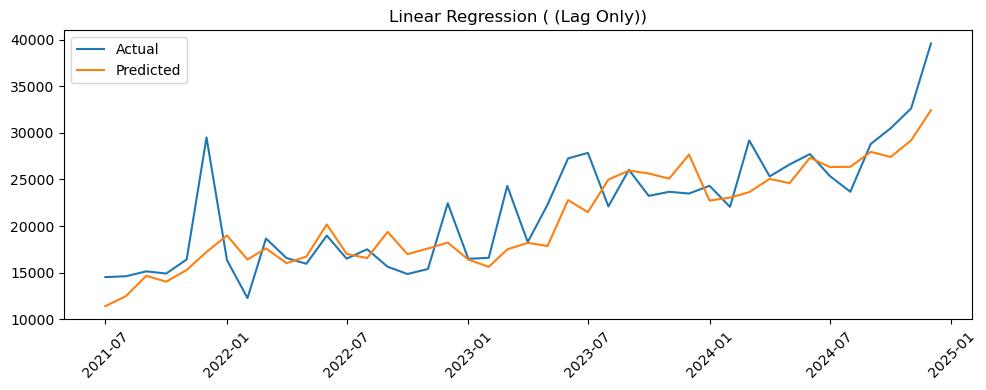

Linear Regression (Keywords + Lag): MAPE=0.1299, MAE=2926.00, RMSE=4113.37, R²=0.536


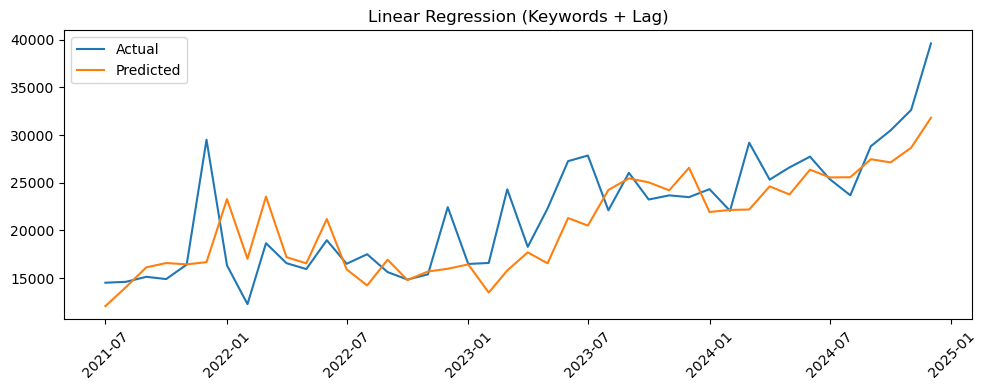

Linear Regression (Bijtelling + Lag): MAPE=0.1148, MAE=2558.10, RMSE=3517.22, R²=0.661


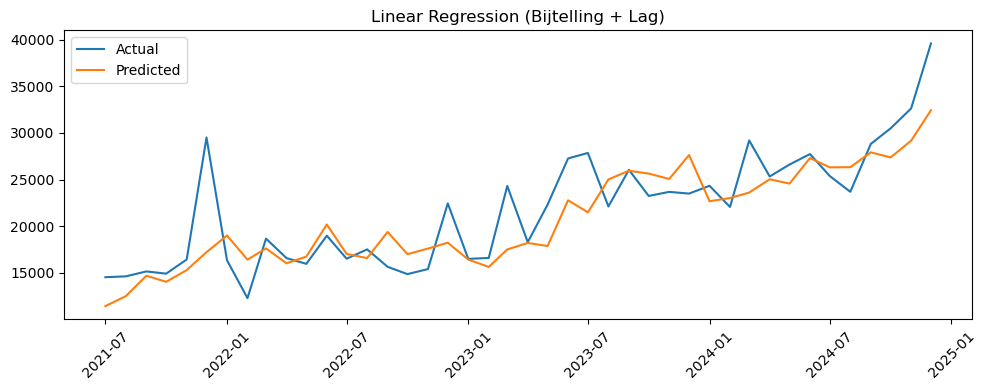

Linear Regression (Confidence + Lag): MAPE=0.1185, MAE=2683.26, RMSE=3761.41, R²=0.612


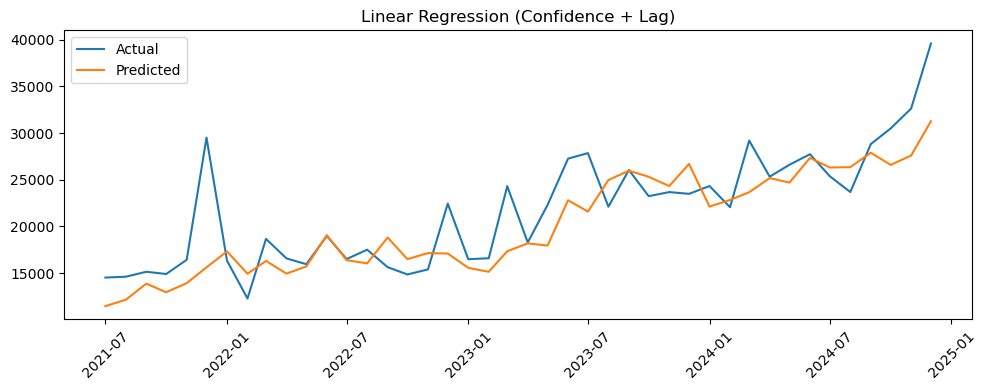

Linear Regression (Fuel + Lag): MAPE=0.1250, MAE=2712.40, RMSE=3579.21, R²=0.649


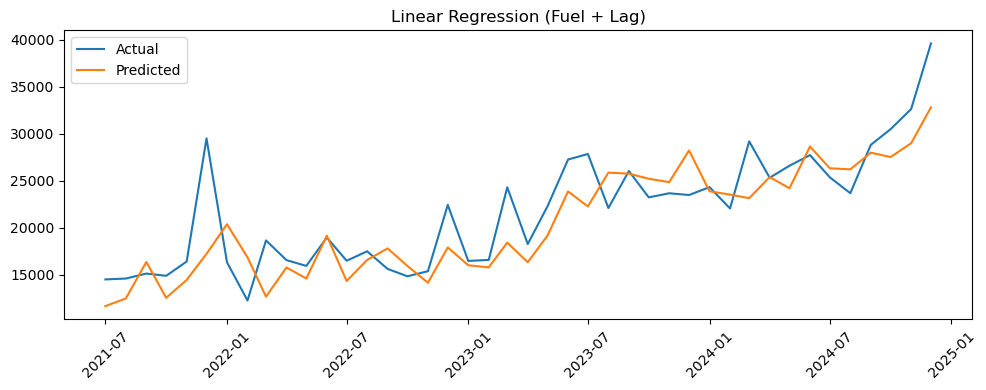

Linear Regression (All Features): MAPE=0.1555, MAE=3368.76, RMSE=4448.30, R²=0.458


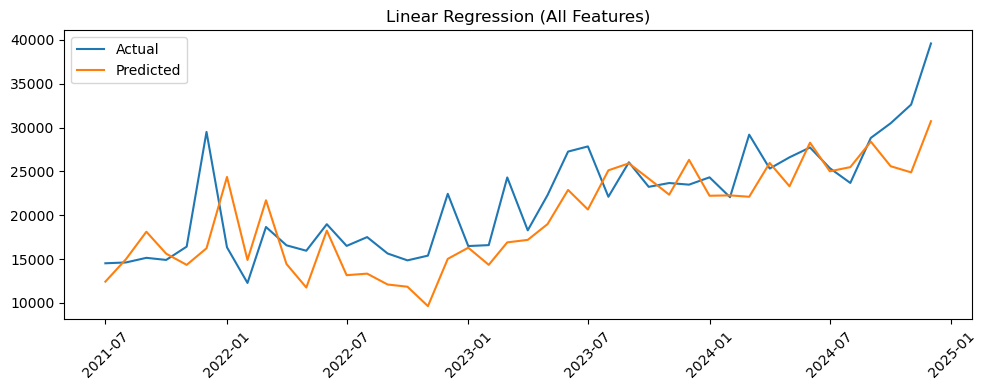

In [7]:
for label, features in feature_sets.items():
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: LinearRegression(), validation_size=1
    )
    print(f"Linear Regression ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    
    plt.figure(figsize=(10, 4))
    plt.plot(validation_dates, val_actuals, label='Actual')
    plt.plot(validation_dates, val_preds, label='Predicted')
    plt.title(f'Linear Regression ({label})')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate date labels for better readability
    plt.tight_layout()       # Ensure there's space for rotated labels
    plt.show()

### XGBOOST

XGBoost ( (Lag Only)): MAPE=0.1198, MAE=2679.24, RMSE=3508.07, R²=0.663


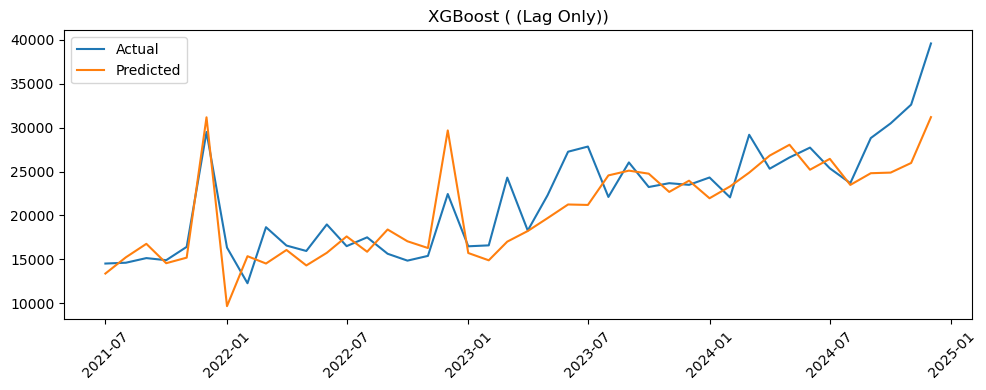

XGBoost (Keywords + Lag): MAPE=0.1286, MAE=2938.21, RMSE=3830.49, R²=0.598


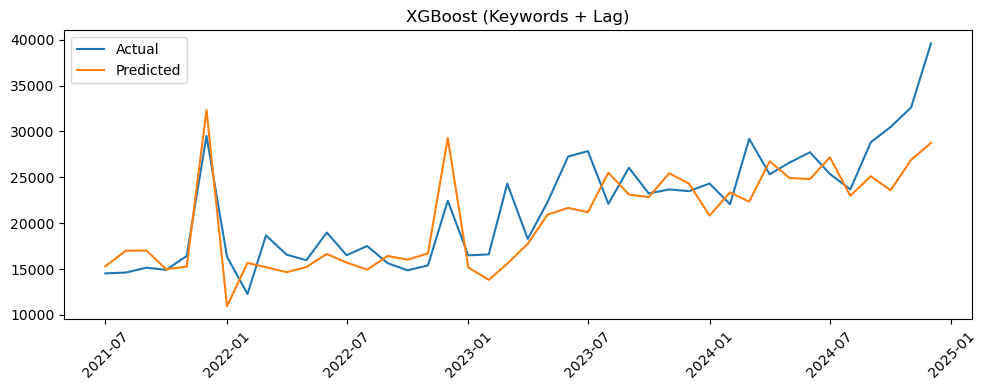

XGBoost (Bijtelling + Lag): MAPE=0.1221, MAE=2722.86, RMSE=3531.09, R²=0.658


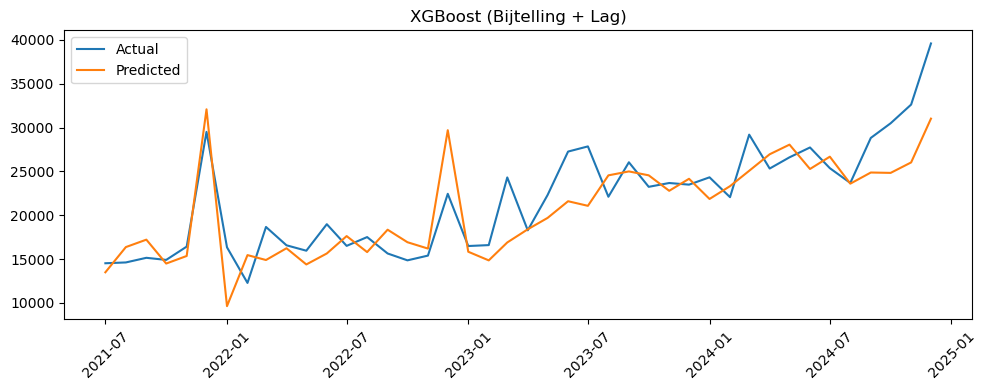

XGBoost (Confidence + Lag): MAPE=0.1235, MAE=2788.03, RMSE=3616.40, R²=0.642


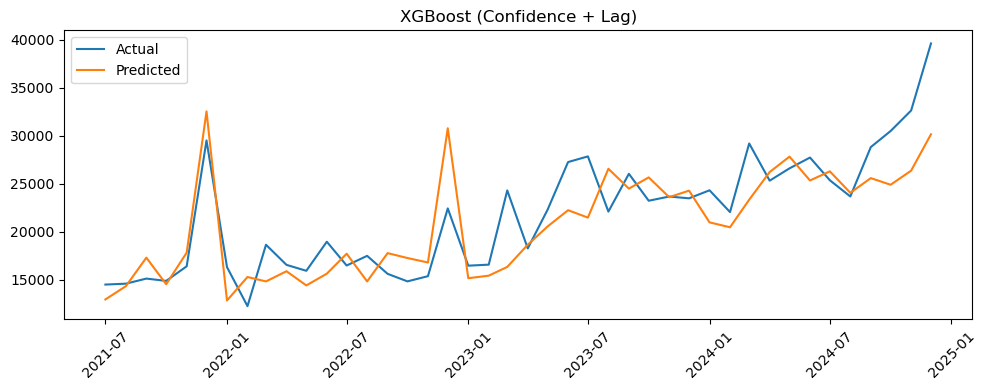

XGBoost (Fuel + Lag): MAPE=0.1172, MAE=2682.38, RMSE=3759.06, R²=0.613


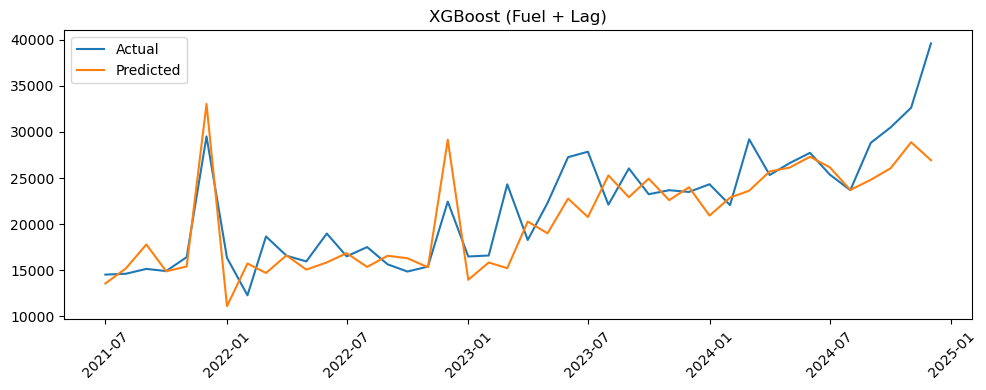

XGBoost (All Features): MAPE=0.1115, MAE=2587.23, RMSE=3708.37, R²=0.623


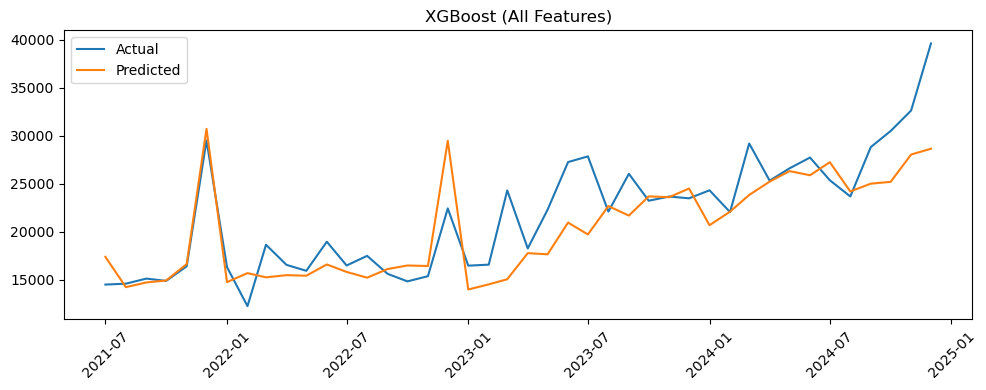

In [8]:
for label, features in feature_sets.items():
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
        lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, 
                                learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse"),
        validation_size=1
    )
    print(f"XGBoost ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    
    plt.figure(figsize=(10, 4))
    plt.plot(validation_dates, val_actuals, label='Actual')
    plt.plot(validation_dates, val_preds, label='Predicted')
    plt.title(f'XGBoost ({label})')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate date labels for better readability
    plt.tight_layout()       # Ensure there's space for rotated labels
    plt.show()

### Arimax 

ARIMAX ( (Lag Only)): MAPE=1.2102, MAE=20116.08, RMSE=57890.22, R²=-90.837


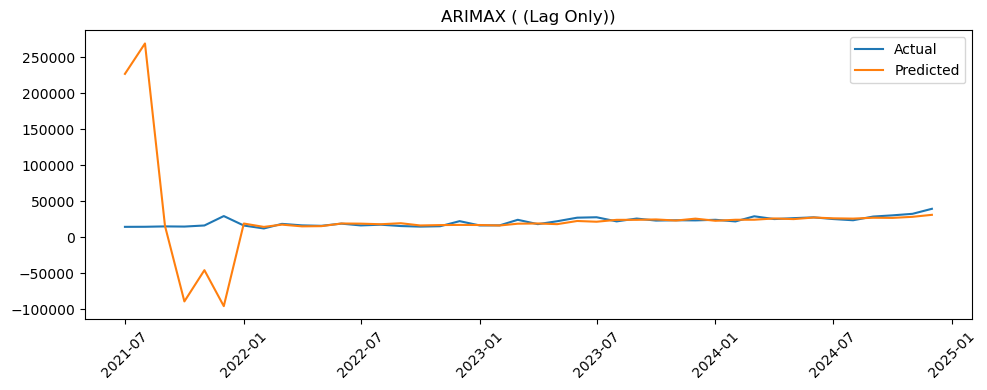

ARIMAX (Keywords + Lag): MAPE=0.1174, MAE=2658.88, RMSE=3669.77, R²=0.631


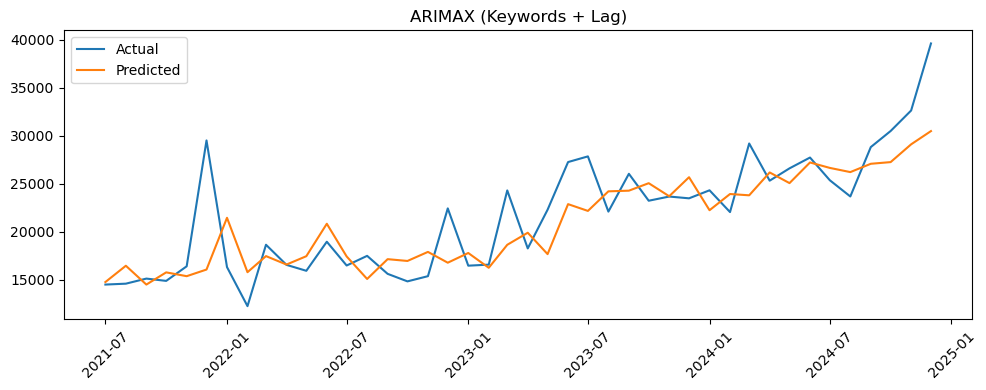

ARIMAX (Bijtelling + Lag): MAPE=0.1019, MAE=2372.49, RMSE=3445.93, R²=0.675


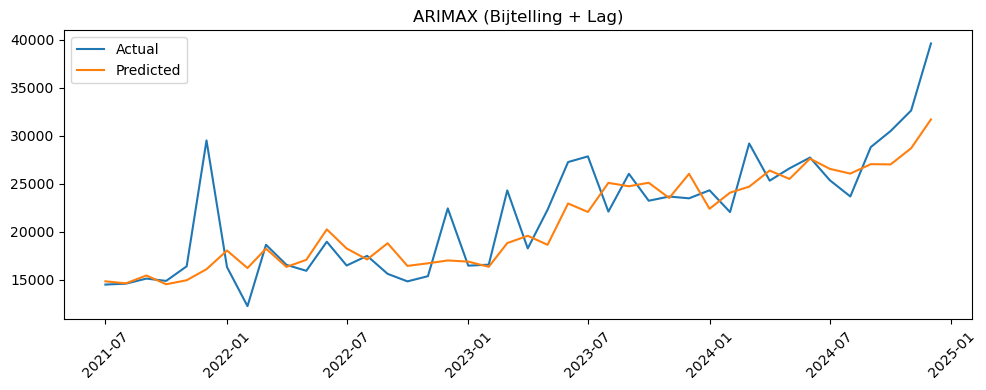

ARIMAX (Confidence + Lag): MAPE=3.4227, MAE=75866.88, RMSE=110797.65, R²=-335.408


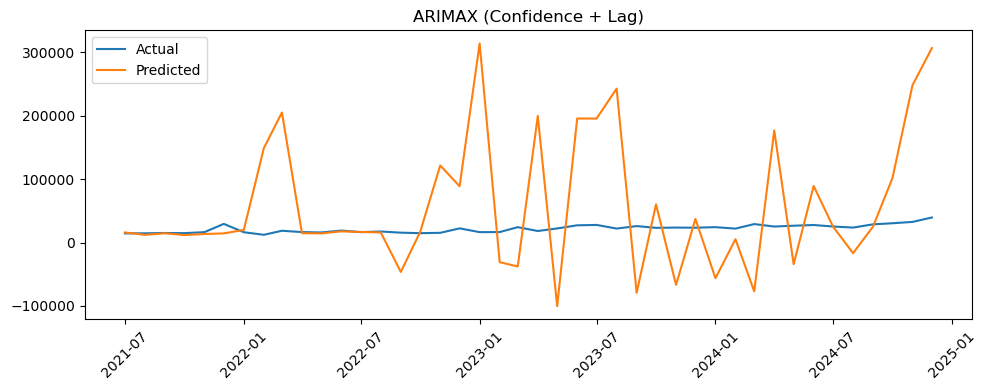

ARIMAX (Fuel + Lag): MAPE=0.1112, MAE=2519.24, RMSE=3487.79, R²=0.667


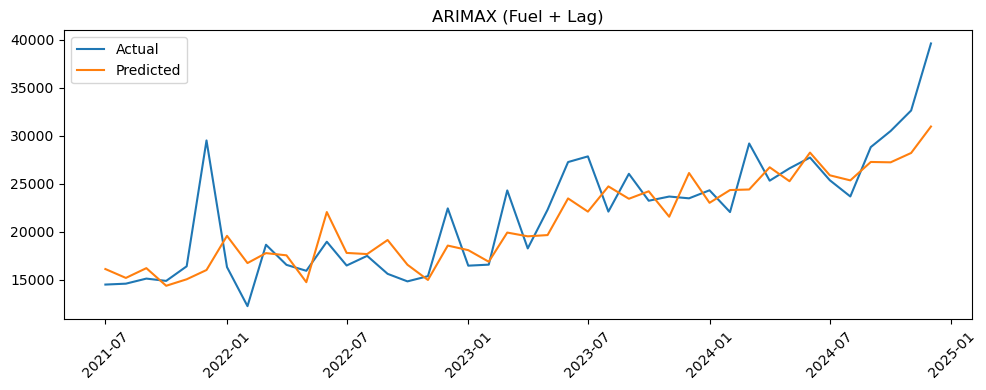

ARIMAX (All Features): MAPE=2.6390, MAE=49600.30, RMSE=89090.86, R²=-216.506


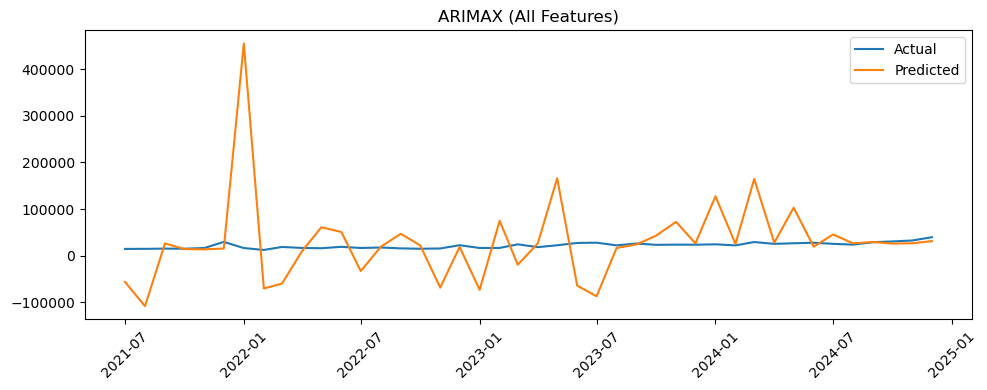

In [9]:
# First create a wrapper class for ARIMAX to make it compatible with walk_forward_validation
class ARIMAXWrapper:
    def __init__(self, order=(1,1,1)):
        self.order = order
        self.model_fit = None
        
    def fit(self, X, y):
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        model = SARIMAX(y, exog=X, order=self.order, enforce_stationarity=False, enforce_invertibility=False)
        self.model_fit = model.fit(disp=False)
        return self
        
    def predict(self, X):
        if self.model_fit is None:
            raise ValueError("Model not fitted yet")
        # For ARIMAX, predict uses forecast with exog data
        return self.model_fit.forecast(steps=len(X), exog=X)

# Now use this wrapper in your walk-forward validation
for label, features in feature_sets.items():
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
        lambda: ARIMAXWrapper(order=(1,1,1)),
        validation_size=1
    )
    print(f"ARIMAX ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    
    plt.figure(figsize=(10, 4))
    plt.plot(validation_dates, val_actuals, label='Actual')
    plt.plot(validation_dates, val_preds, label='Predicted')
    plt.title(f'ARIMAX ({label})')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate date labels for better readability
    plt.tight_layout()       # Ensure there's space for rotated labels
    plt.show()

## Hyperparameter Tuning

XGboost: zodra gpt weet werkt waardes aanpasssen, alleen parameters aanpassen die meeste invloed hebben  (documantatie over lezen)
https://xgboosting.com/tune-xgboost-learning_rate-parameter/



--- Starting optimization for lag-only features ---

--- Starting optimization for all features ---

----- RESULTS -----

Best parameters (Lag-Only Features): max_depth=7, learning_rate=0.0782, n_estimators=88, subsample=0.64, min_child_weight=9, colsample_bytree=0.78
Best MAPE (Lag-Only Features): 0.1185

Best parameters (All Features): max_depth=3, learning_rate=0.2543, n_estimators=106, subsample=0.50, min_child_weight=8, colsample_bytree=0.39
Best MAPE (All Features): 0.1143

----- EVALUATING MODELS WITH OPTIMIZED PARAMETERS -----
Optimized XGBoost (Lag-Only): MAPE=0.1185, MAE=2823.87
Optimized XGBoost (All Features): MAPE=0.1143, MAE=2628.44


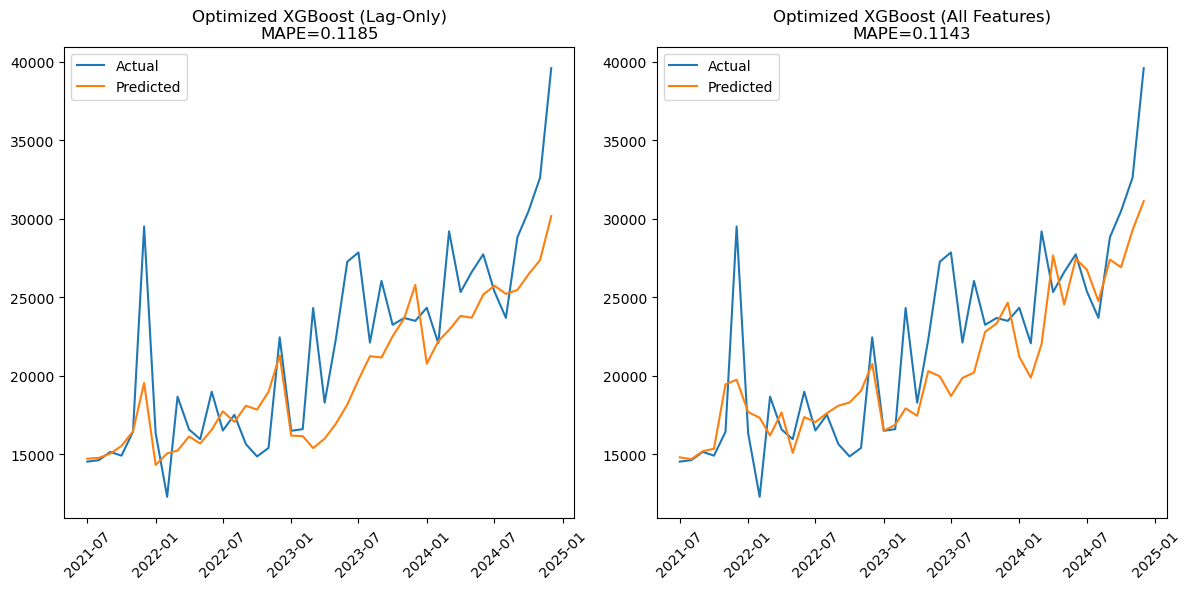

In [10]:
from skopt import gp_minimize  # Import Bayesian optimization function from scikit-optimize

# ------------ LAGGED FEATURES OPTIMIZATION ------------

# Define the objective function for walk-forward validation with lagged features only
def wf_objective_lag(params):
    # Unpack hyperparameters from the params list
    max_depth, learning_rate, n_estimators, subsample, min_child_weight, colsample_bytree = params
    
    # Create an XGBoost regressor with the given hyperparameters
    model = lambda: xgb.XGBRegressor(
        objective='reg:squarederror',           # Use squared error for regression
        max_depth=int(max_depth),               # Maximum tree depth (integer)
        learning_rate=learning_rate,            # Learning rate (float)
        n_estimators=int(n_estimators),         # Number of boosting rounds (integer)
        subsample=subsample,                    # Subsample ratio of the training instances
        min_child_weight=int(min_child_weight), # Minimum sum of instance weight needed in a child
        colsample_bytree=colsample_bytree,      # Subsample ratio of columns when constructing each tree
        random_state=42,                        # Set random seed for reproducibility
        eval_metric="rmse"                      # Evaluation metric: root mean squared error
    )
    
    # Get the lag-only features
    lag_features = feature_sets[' (Lag Only)']
    
    # Run walk-forward validation and get validation MAPE (mean absolute percentage error)
    _, _, _, _, _, _, val_mae, _, _, val_mape, _, _, _ = walk_forward_validation_with_validation_set(
        df_lagged, lag_features, 'Totaal_verkochte_wegvoertuigen', model, validation_size=1
    )
    return val_mape  # Return validation MAPE to minimize

# ------------ ALL FEATURES OPTIMIZATION ------------

# Define the objective function for walk-forward validation with all features
def wf_objective_all(params):
    # Unpack hyperparameters from the params list
    max_depth, learning_rate, n_estimators, subsample, min_child_weight, colsample_bytree = params
    
    # Create an XGBoost regressor with the given hyperparameters
    model = lambda: xgb.XGBRegressor(
        objective='reg:squarederror',           # Use squared error for regression
        max_depth=int(max_depth),               # Maximum tree depth (integer)
        learning_rate=learning_rate,            # Learning rate (float)
        n_estimators=int(n_estimators),         # Number of boosting rounds (integer)
        subsample=subsample,                    # Subsample ratio of the training instances
        min_child_weight=int(min_child_weight), # Minimum sum of instance weight needed in a child
        colsample_bytree=colsample_bytree,      # Subsample ratio of columns when constructing each tree
        random_state=42,                        # Set random seed for reproducibility
        eval_metric="rmse"                      # Evaluation metric: root mean squared error
    )
    
    # Run walk-forward validation and get validation MAPE (mean absolute percentage error)
    _, _, _, _, _, _, val_mae, _, _, val_mape, _, _, _ = walk_forward_validation_with_validation_set(
        df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen', model, validation_size=1
    )
    return val_mape  # Return validation MAPE to minimize

# Define the search space for each hyperparameter (same for both feature sets)
wf_space = [
    (2, 10),                # max_depth: integer between 2 and 10
    (0.01, 0.3),            # learning_rate: float between 0.01 and 0.3
    (50, 300),              # n_estimators: integer between 50 and 300
    (0.5, 1.0),             # subsample: float between 0.5 and 1.0
    (1, 10),                # min_child_weight: integer between 1 and 10
    (0.2, 0.9)              # colsample_bytree: float between 0.2 and 0.9
]

# Run Bayesian optimization to find the best hyperparameters for lag-only features
print("\n--- Starting optimization for lag-only features ---")
wf_result_lag = gp_minimize(wf_objective_lag, wf_space, n_calls=25, random_state=42)

# Run Bayesian optimization to find the best hyperparameters for all features
print("\n--- Starting optimization for all features ---")
wf_result_all = gp_minimize(wf_objective_all, wf_space, n_calls=25, random_state=42)

# Print the best hyperparameters and the corresponding best MAPE for lag-only features
print("\n----- RESULTS -----")
print(f"\nBest parameters (Lag-Only Features): max_depth={int(wf_result_lag.x[0])}, learning_rate={wf_result_lag.x[1]:.4f}, "
      f"n_estimators={int(wf_result_lag.x[2])}, subsample={wf_result_lag.x[3]:.2f}, "
      f"min_child_weight={int(wf_result_lag.x[4])}, colsample_bytree={wf_result_lag.x[5]:.2f}")
print(f"Best MAPE (Lag-Only Features): {wf_result_lag.fun:.4f}")

# Print the best hyperparameters and the corresponding best MAPE for all features
print(f"\nBest parameters (All Features): max_depth={int(wf_result_all.x[0])}, learning_rate={wf_result_all.x[1]:.4f}, "
      f"n_estimators={int(wf_result_all.x[2])}, subsample={wf_result_all.x[3]:.2f}, "
      f"min_child_weight={int(wf_result_all.x[4])}, colsample_bytree={wf_result_all.x[5]:.2f}")
print(f"Best MAPE (All Features): {wf_result_all.fun:.4f}")

# Compare models with optimized parameters
print("\n----- EVALUATING MODELS WITH OPTIMIZED PARAMETERS -----")

# Define optimized models
lag_opt_model = lambda: xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=int(wf_result_lag.x[0]),
    learning_rate=wf_result_lag.x[1],
    n_estimators=int(wf_result_lag.x[2]),
    subsample=wf_result_lag.x[3],
    min_child_weight=int(wf_result_lag.x[4]),
    colsample_bytree=wf_result_lag.x[5],
    random_state=42,
    eval_metric="rmse"
)

all_opt_model = lambda: xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=int(wf_result_all.x[0]),
    learning_rate=wf_result_all.x[1],
    n_estimators=int(wf_result_all.x[2]),
    subsample=wf_result_all.x[3],
    min_child_weight=int(wf_result_all.x[4]),
    colsample_bytree=wf_result_all.x[5],
    random_state=42,
    eval_metric="rmse"
)

# Evaluate the model with lag-only features and its optimized parameters
lag_features = feature_sets[' (Lag Only)']
_, _, _, _, _, _, lag_mae, _, _, lag_mape, lag_preds, lag_actuals, lag_dates = walk_forward_validation_with_validation_set(
    df_lagged, lag_features, 'Totaal_verkochte_wegvoertuigen', lag_opt_model, validation_size=1
)
print(f"Optimized XGBoost (Lag-Only): MAPE={lag_mape:.4f}, MAE={lag_mae:.2f}")

# Evaluate the model with all features and its optimized parameters
_, _, _, _, _, _, all_mae, _, _, all_mape, all_preds, all_actuals, all_dates = walk_forward_validation_with_validation_set(
    df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen', all_opt_model, validation_size=1
)
print(f"Optimized XGBoost (All Features): MAPE={all_mape:.4f}, MAE={all_mae:.2f}")

# Plot results for both models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lag_dates, lag_actuals, label='Actual')
plt.plot(lag_dates, lag_preds, label='Predicted')
plt.title(f'Optimized XGBoost (Lag-Only)\nMAPE={lag_mape:.4f}')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(all_dates, all_actuals, label='Actual')
plt.plot(all_dates, all_preds, label='Predicted')
plt.title(f'Optimized XGBoost (All Features)\nMAPE={all_mape:.4f}')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

In [11]:
from skopt import gp_minimize  # Import Bayesian optimization function from scikit-optimize

# Define the objective function for walk-forward validation
def wf_objective(params):
    # Unpack hyperparameters from the params list
    max_depth, learning_rate, n_estimators, subsample, min_child_weight, colsample_bytree = params
    # Create an XGBoost regressor with the given hyperparameters
    model = lambda: xgb.XGBRegressor(
        objective='reg:squarederror',           # Use squared error for regression
        max_depth=int(max_depth),               # Maximum tree depth (integer)
        learning_rate=learning_rate,            # Learning rate (float)
        n_estimators=int(n_estimators),         # Number of boosting rounds (integer)
        subsample=subsample,                    # Subsample ratio of the training instances
        min_child_weight=int(min_child_weight), # Minimum sum of instance weight needed in a child
        colsample_bytree=colsample_bytree,      # Subsample ratio of columns when constructing each tree
        random_state=42,                        # Set random seed for reproducibility
        eval_metric="rmse"                      # Evaluation metric: root mean squared error
    )
    # Run walk-forward validation and get validation MAPE (mean absolute percentage error)
    _, _, _, _, _, _, val_mae, _, _, val_mape, _, _, _ = walk_forward_validation_with_validation_set(
        df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen', model, validation_size=1
    )
    return val_mape  # Return validation MAPE to minimize

# Define the search space for each hyperparameter
wf_space = [
    (2, 10),                # max_depth: integer between 2 and 10
    (0.001, 0.01, 0.3),            # learning_rate: float between 0.01 and 0.3
    (50, 300),              # n_estimators: integer between 50 and 300
    (0.5, 1.0),             # subsample: float between 0.5 and 1.0
    (1, 10),                # min_child_weight: integer between 1 and 10
    (0.2, 0.9)              # colsample_bytree: float between 0.2 and 0.9
]

# Run Bayesian optimization to find the best hyperparameters
wf_result = gp_minimize(wf_objective, wf_space, n_calls=50, random_state=42)
# Print the best hyperparameters and the corresponding best MAPE
print(f"Best parameters (Walk-Forward): max_depth={int(wf_result.x[0])}, learning_rate={wf_result.x[1]:.4f}, "
      f"n_estimators={int(wf_result.x[2])}, subsample={wf_result.x[3]:.2f}, "
      f"min_child_weight={int(wf_result.x[4])}, colsample_bytree={wf_result.x[5]:.2f}")
print(f"Best MAPE (Walk-Forward): {wf_result.fun:.4f}")


Best parameters (Walk-Forward): max_depth=2, learning_rate=0.3000, n_estimators=154, subsample=0.51, min_child_weight=10, colsample_bytree=0.47
Best MAPE (Walk-Forward): 0.1204


### Shap

# Test

### LR

Linear Regression ( (Lag Only)): MAPE=0.1117, MAE=2546.43, RMSE=3521.89, R²=0.677


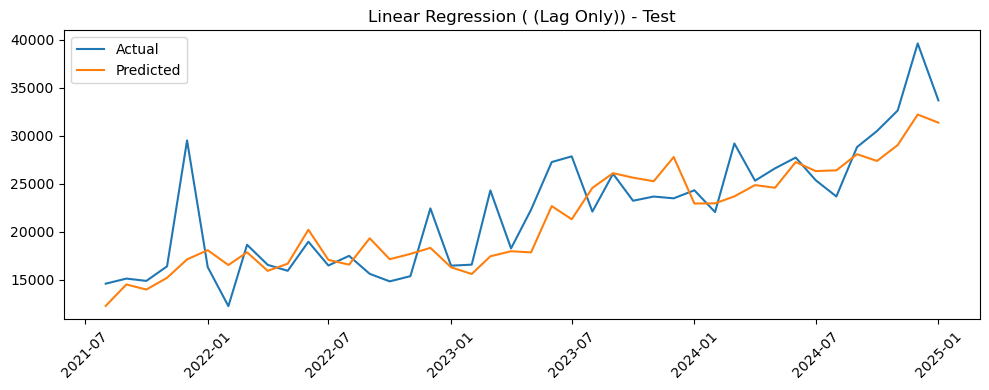

Linear Regression (Keywords + Lag): MAPE=0.1337, MAE=3042.31, RMSE=4226.67, R²=0.535


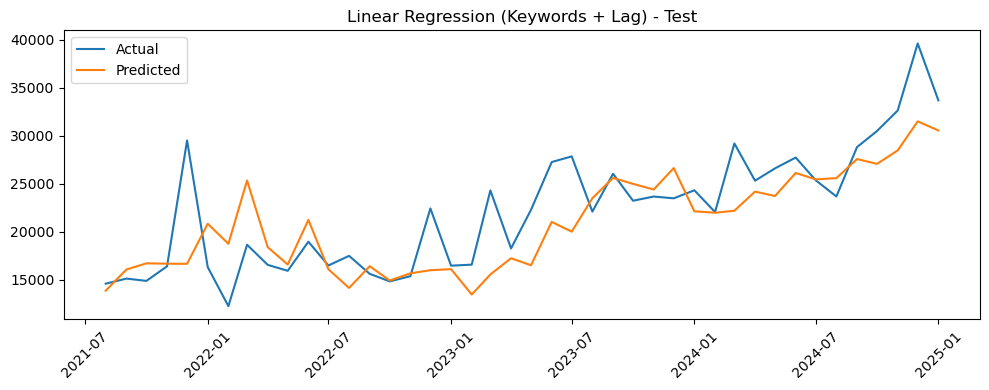

Linear Regression (Bijtelling + Lag): MAPE=0.1118, MAE=2552.88, RMSE=3529.13, R²=0.676


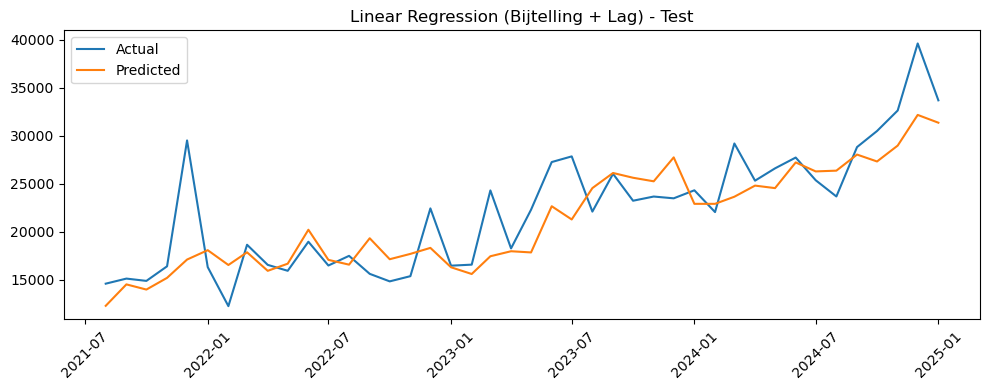

Linear Regression (Confidence + Lag): MAPE=0.1203, MAE=2784.75, RMSE=3871.54, R²=0.610


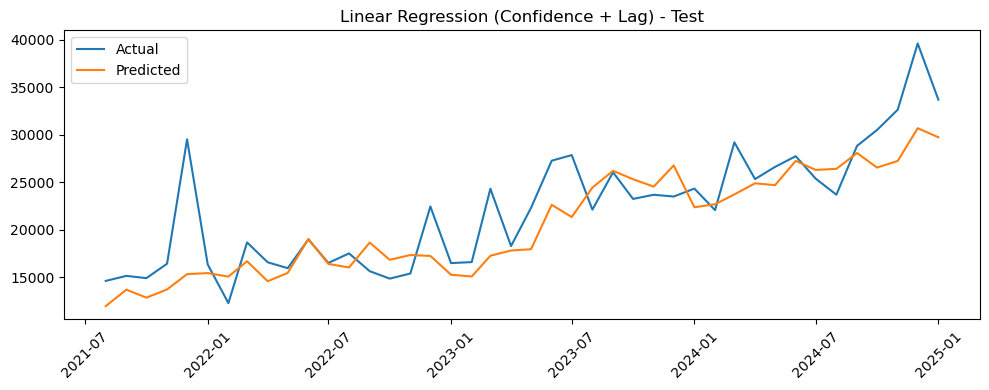

Linear Regression (Fuel + Lag): MAPE=0.1228, MAE=2713.82, RMSE=3589.39, R²=0.665


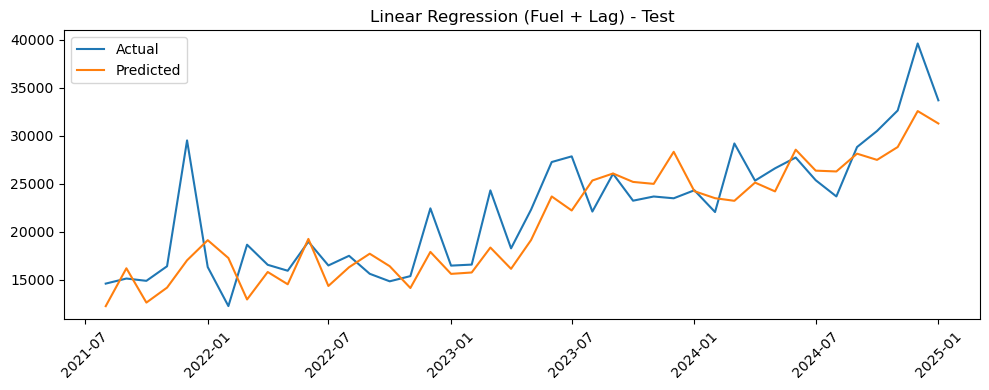

Linear Regression (All Features): MAPE=0.1632, MAE=3562.65, RMSE=4652.30, R²=0.437


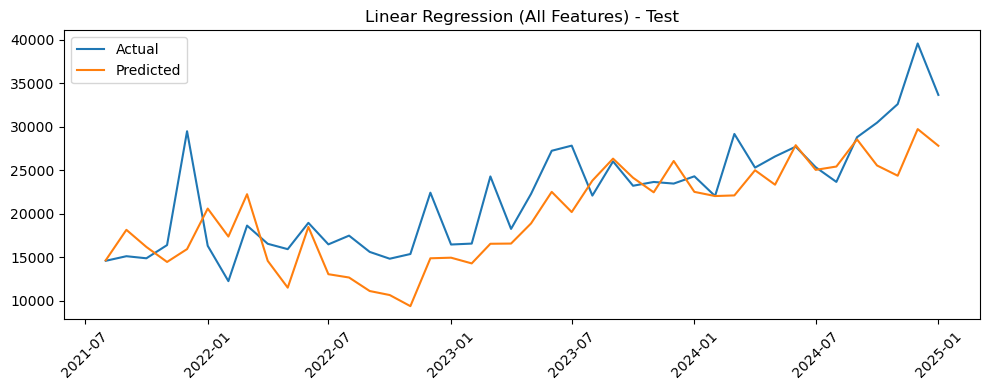

In [15]:
for label, features in feature_sets.items():
    (
        mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, test_mape, val_preds, test_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: LinearRegression(), validation_size=1
    )
    print(f"Linear Regression ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")

    # For test visualization (assuming monthly data)
    test_dates = [pd.to_datetime(date) + pd.DateOffset(months=1) for date in validation_dates]

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, actuals[:len(test_dates)], label='Actual')
    plt.plot(test_dates, preds[:len(test_dates)], label='Predicted')
    plt.title(f'Linear Regression ({label}) - Test')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Arimax

ARIMAX ( (Lag Only)): MAPE=1.2403, MAE=20805.91, RMSE=57715.63, R²=-85.693


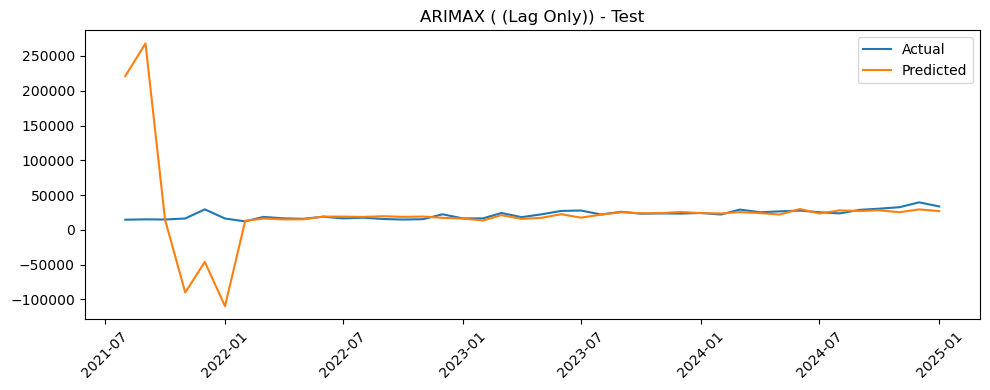

ARIMAX (Keywords + Lag): MAPE=0.1354, MAE=3177.50, RMSE=4336.23, R²=0.511


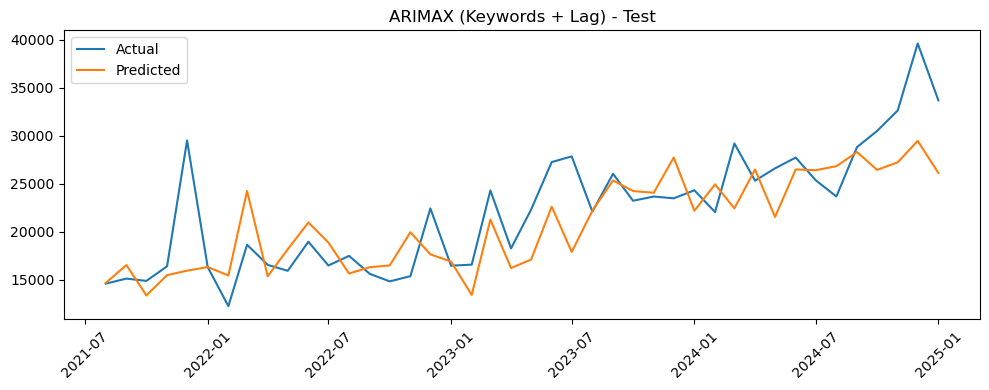

ARIMAX (Bijtelling + Lag): MAPE=0.1244, MAE=2943.09, RMSE=4080.55, R²=0.567


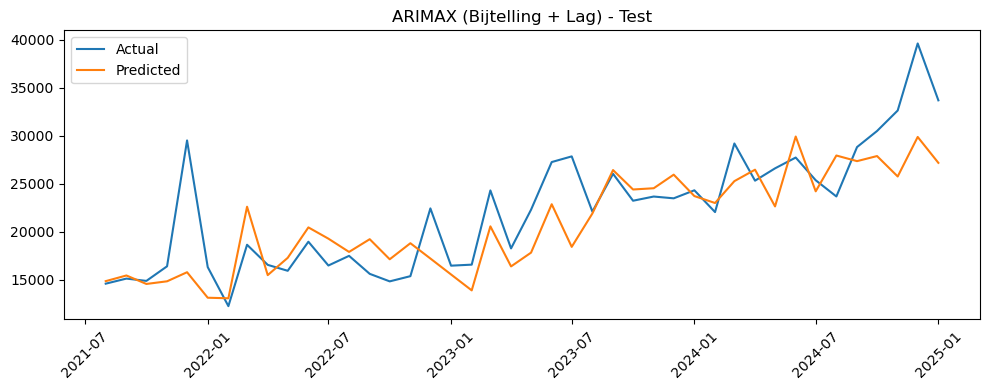

ARIMAX (Confidence + Lag): MAPE=3.3169, MAE=76249.26, RMSE=109931.91, R²=-313.517


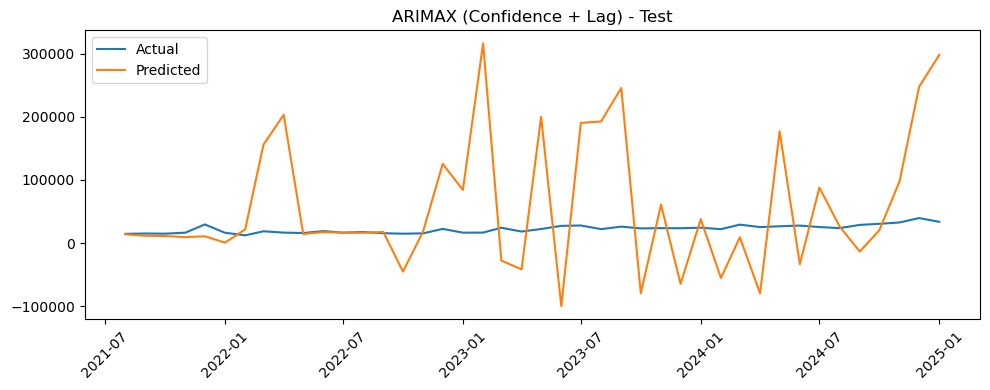

ARIMAX (Fuel + Lag): MAPE=0.1224, MAE=2863.31, RMSE=4125.82, R²=0.557


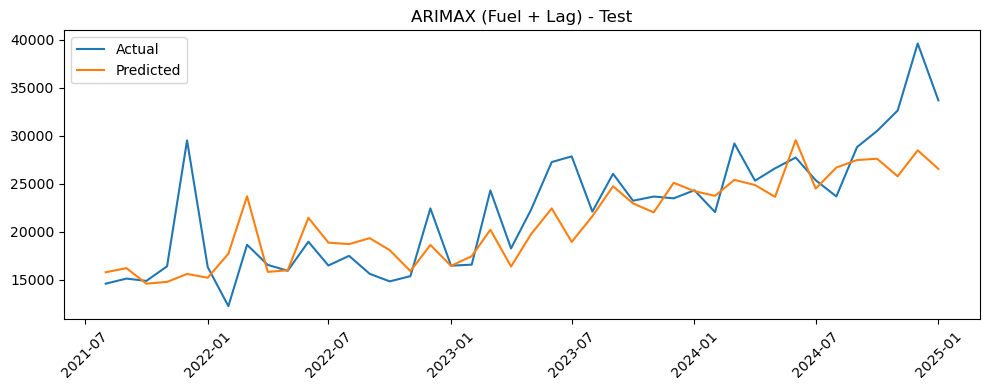

ARIMAX (All Features): MAPE=2.7928, MAE=50469.91, RMSE=89580.84, R²=-207.847


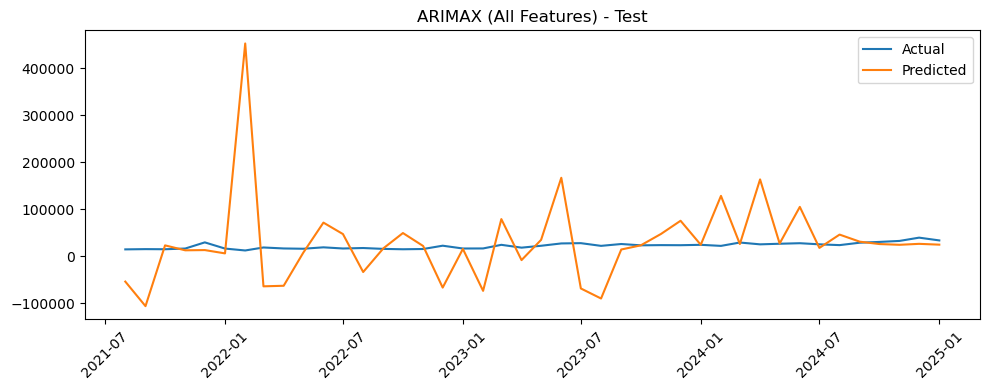

In [17]:
# First create a wrapper class for ARIMAX to make it compatible with walk_forward_validation
class ARIMAXWrapper:
    def __init__(self, order=(1,1,1)):
        self.order = order
        self.model_fit = None
        
    def fit(self, X, y):
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        model = SARIMAX(y, exog=X, order=self.order, enforce_stationarity=False, enforce_invertibility=False)
        self.model_fit = model.fit(disp=False)
        return self
        
    def predict(self, X):
        if self.model_fit is None:
            raise ValueError("Model not fitted yet")
        # For ARIMAX, predict uses forecast with exog data
        return self.model_fit.forecast(steps=len(X), exog=X)

# Now use this wrapper in your walk-forward validation to evaluate on the test set.
for label, features in feature_sets.items():
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
        lambda: ARIMAXWrapper(order=(1,1,1)),
        validation_size=1
    )
    print(f"ARIMAX ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    
    # For test visualization (assuming monthly data)
    test_dates = [pd.to_datetime(date) + pd.DateOffset(months=1) for date in validation_dates]

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, actuals[:len(test_dates)], label='Actual')
    plt.plot(test_dates, preds[:len(test_dates)], label='Predicted')
    plt.title(f'ARIMAX ({label}) - Test')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### XGboost

#### parameters for lag only 

XGBoost ( (Lag Only)): MAPE=0.1399, MAE=3380.31, RMSE=4627.70, R²=0.443


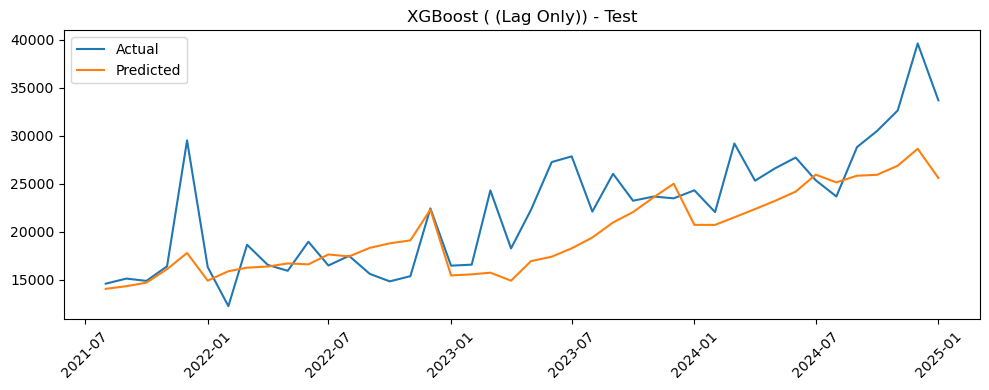

XGBoost (Keywords + Lag): MAPE=0.1394, MAE=3403.44, RMSE=4774.37, R²=0.407


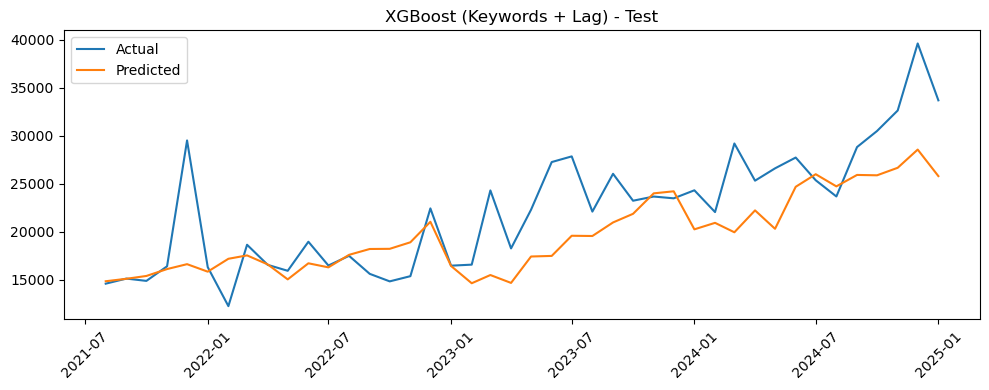

XGBoost (Bijtelling + Lag): MAPE=0.1380, MAE=3394.41, RMSE=4692.56, R²=0.427


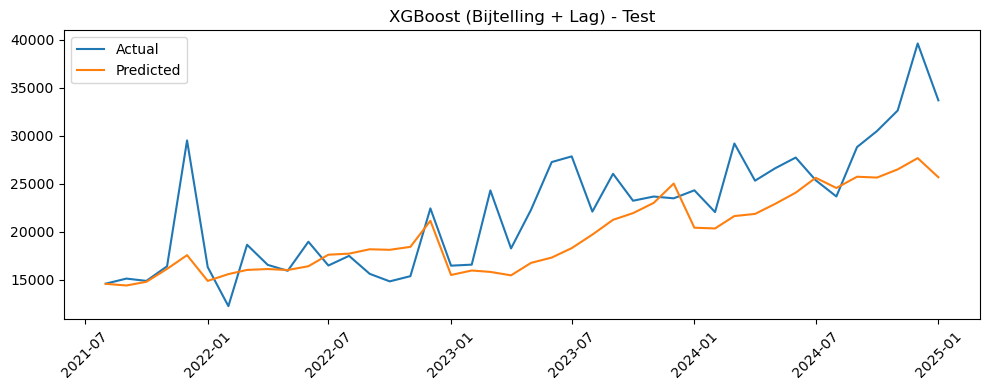

XGBoost (Confidence + Lag): MAPE=0.1418, MAE=3418.07, RMSE=4649.04, R²=0.437


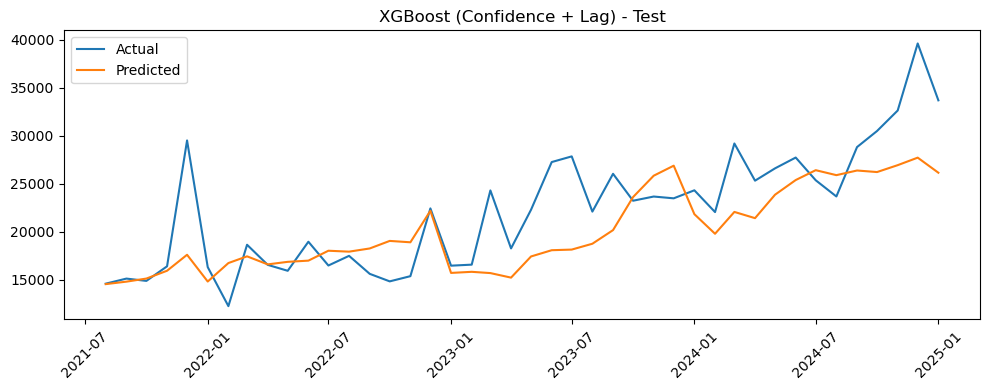

XGBoost (Fuel + Lag): MAPE=0.1461, MAE=3531.94, RMSE=4752.17, R²=0.412


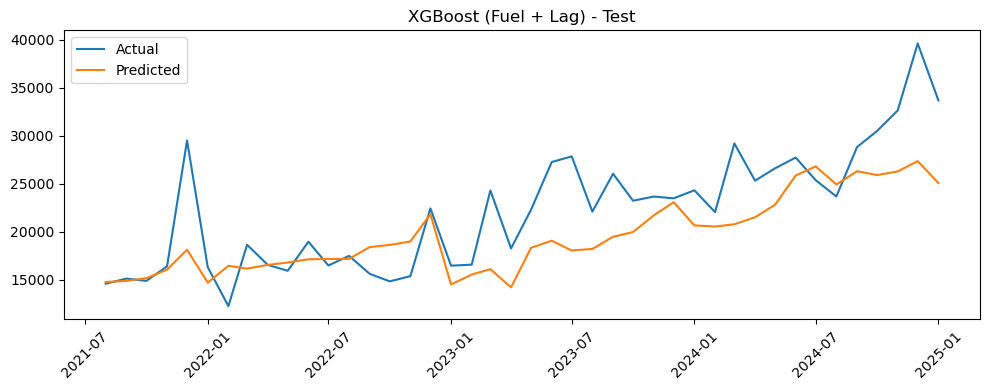

XGBoost (All Features): MAPE=0.1501, MAE=3603.82, RMSE=4931.61, R²=0.367


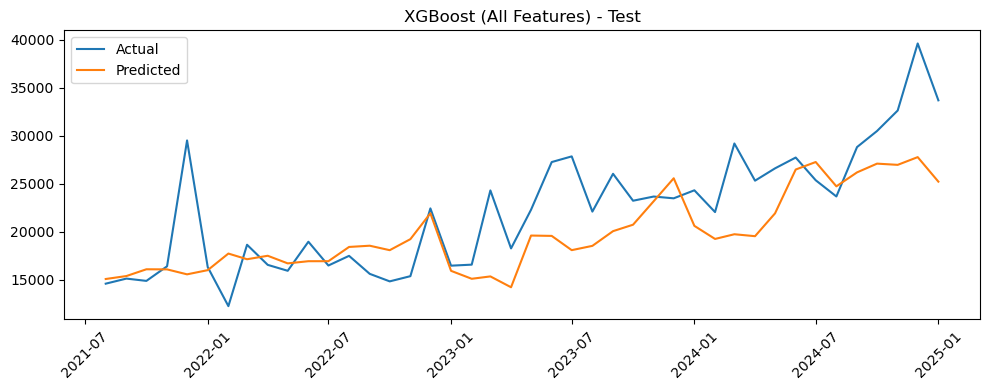

In [19]:
for label, features in feature_sets.items():
    (
        mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror', 
            max_depth=7, learning_rate=0.0782, n_estimators=88, subsample=0.64, min_child_weight=9, colsample_bytree=0.78, 
            eval_metric="rmse"
        ),
        validation_size=1
    )
    print(f"XGBoost ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    
    # For test visualization (assuming monthly data)
    test_dates = [pd.to_datetime(date) + pd.DateOffset(months=1) for date in validation_dates]

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, actuals[:len(test_dates)], label='Actual')
    plt.plot(test_dates, preds[:len(test_dates)], label='Predicted')
    plt.title(f'XGBoost ({label}) - Test')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### parameters for all features

XGBoost ( (Lag Only)): MAPE=0.1605, MAE=3727.01, RMSE=4665.87, R²=0.433


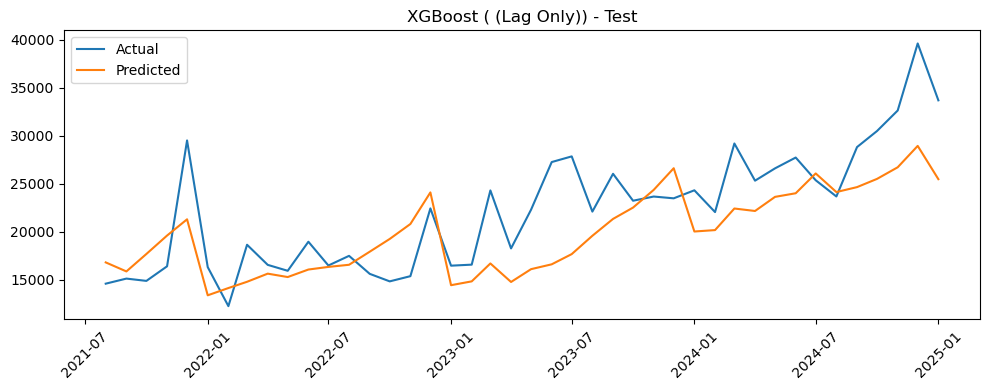

XGBoost (Keywords + Lag): MAPE=0.1550, MAE=3694.20, RMSE=4942.81, R²=0.364


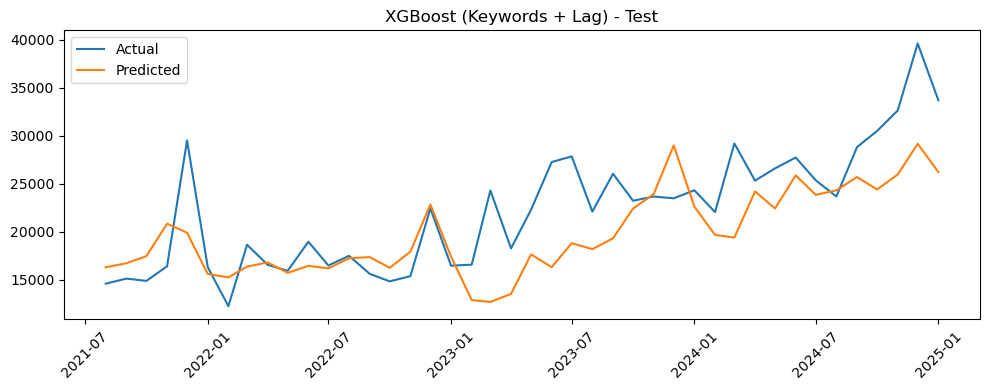

XGBoost (Bijtelling + Lag): MAPE=0.1671, MAE=3821.13, RMSE=4842.20, R²=0.390


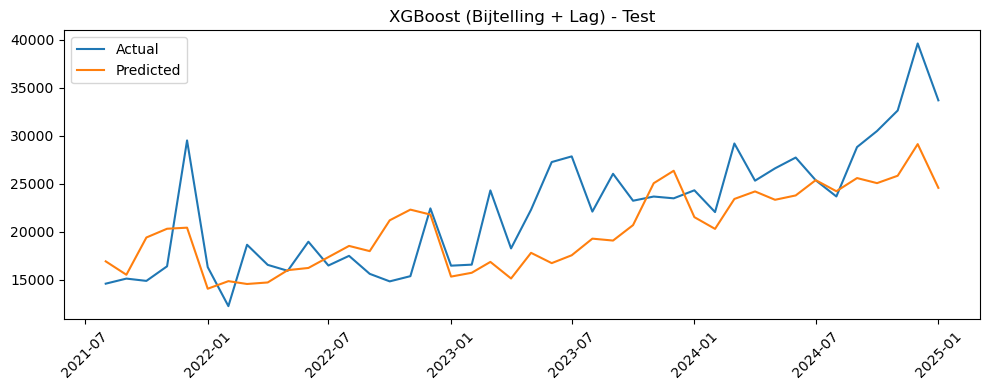

XGBoost (Confidence + Lag): MAPE=0.1619, MAE=3676.61, RMSE=4655.30, R²=0.436


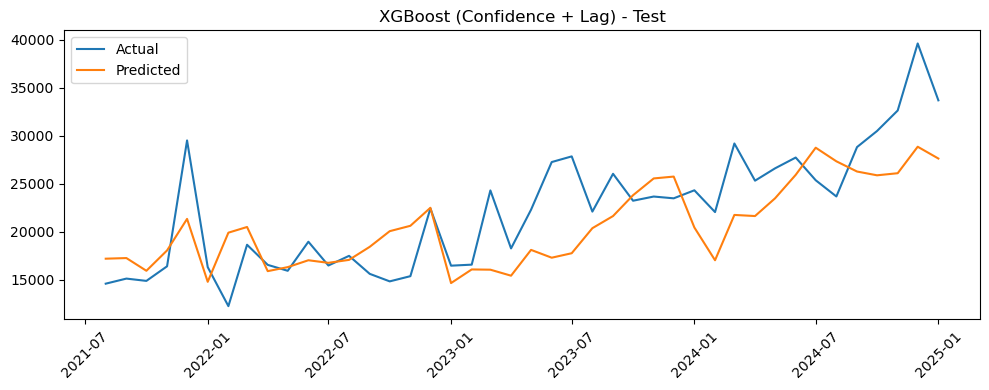

XGBoost (Fuel + Lag): MAPE=0.1535, MAE=3634.59, RMSE=4665.89, R²=0.433


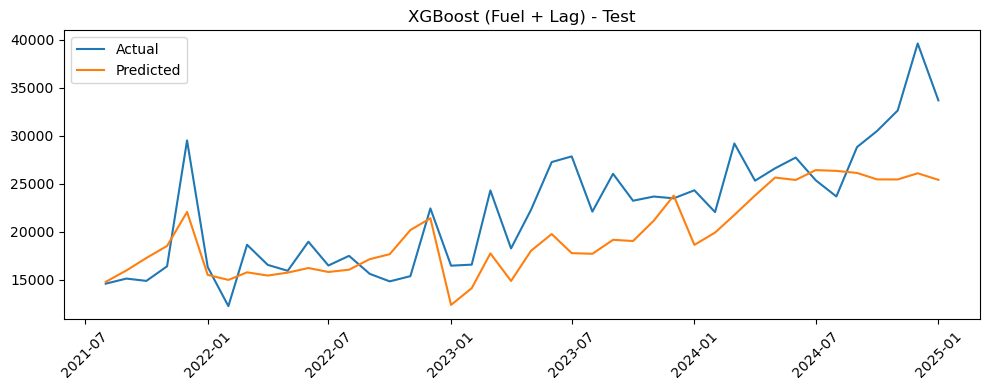

XGBoost (All Features): MAPE=0.1828, MAE=4119.40, RMSE=5257.37, R²=0.281


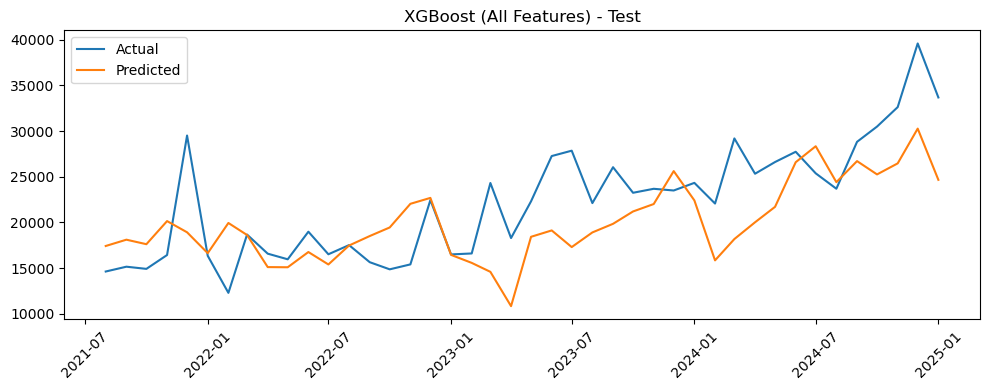

In [20]:
for label, features in feature_sets.items():
    (
        mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror', 
            max_depth=3, learning_rate=0.2543, n_estimators=106, subsample=0.50, min_child_weight=8, colsample_bytree=0.39, 
            eval_metric="rmse"
        ),
        validation_size=1
    )
    print(f"XGBoost ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    
    # For test visualization (assuming monthly data)
    test_dates = [pd.to_datetime(date) + pd.DateOffset(months=1) for date in validation_dates]

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, actuals[:len(test_dates)], label='Actual')
    plt.plot(test_dates, preds[:len(test_dates)], label='Predicted')
    plt.title(f'XGBoost ({label}) - Test')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()